<div style="border-radius: 5px; padding: 1rem; margin-bottom: 1rem">
<img src="https://www.prototypesforhumanity.com/wp-content/uploads/2022/11/LOGO_UTEC_.png" alt="Banner" width="150" />   
 </div>

# Laboratorio 8: Vectorización, Indexación y Reconocimiento de Rostros

> **Prof. Heider Sanchez**  
> **ACLs:** Ana María Accilio, Sebastián Loza

## Introducción

Las imágenes, y específicamente los rostros, representan uno de los tipos más complejos de datos no estructurados, requiriendo técnicas especializadas para su procesamiento y recuperación eficiente.

El manejo de datos biométricos faciales presenta varios retos:
- La necesidad de convertir información visual compleja en representaciones numéricas procesables.
- El almacenamiento eficiente de vectores de alta dimensionalidad (vectores característicos faciales).
- La implementación de búsquedas rápidas y precisas en grandes colecciones de datos.

Este laboratorio aborda estos desafíos explorando diferentes técnicas de indexación vectorial para optimizar la búsqueda de rostros similares. 

El proceso general consiste en:

1. **Vectorización de rostros**: Utilizando la biblioteca `face_recognition`, convertiremos imágenes de rostros en vectores de características (embeddings) de 128 dimensiones que capturan los rasgos faciales distintivos.

2. **Indexación**: Exploraremos diferentes estructuras de indexación para almacenar y buscar eficientemente estos vectores:
   - Búsqueda lineal (fuerza bruta)
   - Índice Multidimensional con GiST
   - Índice de Alta Dimensión con pgvector
   
3. **Búsqueda de similitud**: Implementaremos búsquedas de k vecinos más cercanos (k-NN) para encontrar rostros similares a una imagen de consulta.


## P1. Desempeño del GiST (RTree) en Altas Dimensiones
Vamos empezar el laboratorio evaluando el desempeño del índice multidimensional GIST de PostgreSQL para diferentes dimensiones del vector característico.

- Crear una tabla con dos campos de tipo "cube".
- Poblar la tabla con N puntos aleatorios de D dimensiones en ambos campos.  
  - $N = 10^6$
  - $D = [2,4,6,8,16,32,64]$
- Luego proceder a crear el índice gist sobre uno de ellos.
- Realizar un análisis comparativo de los tiempos de la búsqueda KNN secuencial y la búsqueda KNN indexada para $K=3$.
- Ambas búsquedas, secuencial e indexada, deben usar la misma consulta SQL pero en diferentes campos.
- Capturar los tiempos del plan de ejecución y elabore la tabla de resultados de forma similar a la tabla del apartado anterior.
- Elaborar gráficos comparativos necesarios para responder las siguientes preguntas:
  - ¿A partir de qué valor de N conviene aplicar el RTree en lugar de búsqueda lineal?
  - ¿Hasta qué dimensión D conviene usar el RTree para búsquedas KNN en lugar de la búsqueda lineal?  

### Script SQL

In [ ]:
create extension cube;

drop table if exists vectors;

create table if not exists vectors
(
    id            serial,
    vector_lineal cube,
    vector_gist   cube
);

--Populate the table with random data
insert into vectors(id, vector_lineal)
select id,
       cube(array [
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000),
           round(random() * 1000)
           ])
from generate_series(1, 100000) as id;

update vectors
set vector_gist = vector_lineal;

--Create rtree index
create index idx_vector on vectors using gist (vector_gist);

VACUUM FULL vectors;
VACUUM vectors;

--KNN without index
explain analyze
select id, vector_lineal, cube_distance(vector_lineal, '(638, 616, 153, 907)') as distance
from vectors
order by vector_lineal <-> '(636, 616, 153, 907)'
limit 5;

--KNN with index
explain analyze
select id, vector_gist, cube_distance(vector_gist, '(638, 616, 153, 907)') as distance
from vectors
order by vector_gist <-> '(636, 616, 153, 907)'
limit 5;

### Script Python

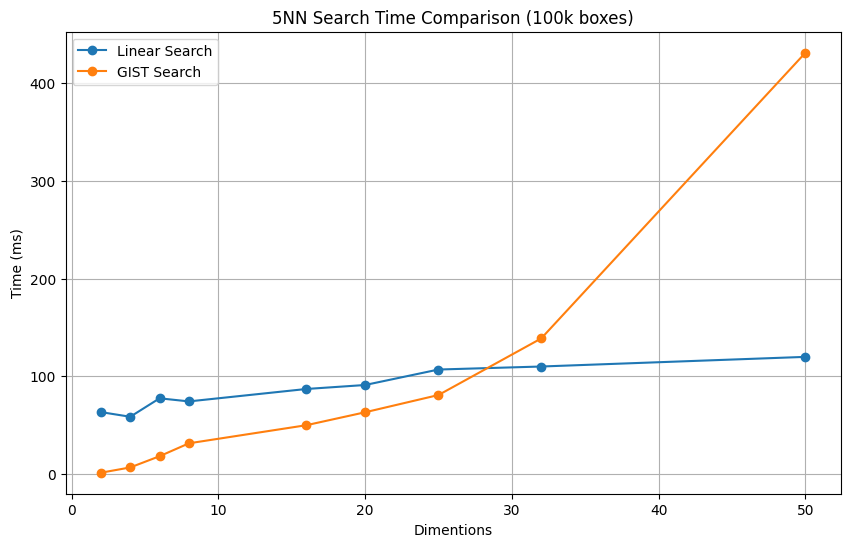

In [1]:
import matplotlib.pyplot as plt

r = {2: (63.231, 1.129),
     4: (58.448, 6.541),
     6: (77.356, 18.043),
     8: (74.181, 31.269),
     16: (86.913, 49.812),
     20: (90.984, 63.046),
     25: (106.838, 80.728),
     32: (109.925, 138.682),
     50: (119.806, 431.364)}

dimentions = list(r.keys())
times_lineal = [t[0] for t in r.values()]
times_gist = [t[1] for t in r.values()]

plt.figure(figsize=(10, 6))
plt.plot(dimentions, times_lineal, marker = 'o', label = 'Linear Search')
plt.plot(dimentions, times_gist, marker = 'o', label = 'GIST Search')
plt.xlabel('Dimentions')
plt.ylabel('Time (ms)')
plt.title('5NN Search Time Comparison (100k boxes)')
plt.legend()
plt.grid(True)
plt.show()

## P2. Cargar el Dataset de Rostros

### Instalación de dependencias

Antes de comenzar, necesitamos instalar las siguientes librerías en Python:

```bash
# Instalar face_recognition (incluye dlib)
conda install -c conda-forge face_recognition

# Instalar librerías para manipulación de datos y visualización
pip install pandas numpy matplotlib

# Instalar Rtree para indexación espacial
pip install Rtree
```

> **Nota**: La instalación de `face_recognition` puede ser compleja en Windows. Se recomienda usar conda para facilitar la instalación de las dependencias.


### Descarga del dataset
Descargar [LFW Dataset](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data) y descomprimir en una carpeta localmente.


In [ ]:
%conda install -c conda-forge face_recognition
%pip install pandas numpy matplotlib
%pip install rtree
%pip install matplotlib
%pip install psycopg2

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

## Package Plan ##

  environment location: c:\Users\Jvnc\Documents\BD2\BD2-Labs\Lab08\.conda

  added / updated specs:
    - face_recognition


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    click-8.2.1                |     pyh7428d3b_0          86 KB  conda-forge
    dlib-19.24.2               |  py312hd8edec2_2         3.2 MB  conda-forge
    expat-2.7.0                |       he0c23c2_0         228 KB  conda-forge
    face_recognition-1.3.0     |     pyhd3deb0d_2          17 KB  conda-forge
    face_recognition_models-0.3.0|     pyh9f0ad1d_0        87.7 MB  conda-forge
    freetype-2.12.1            |       hdaf720e_2         498 KB  conda-forge
    intel-openmp-2024.2.1      |    h57928b3_1083         1.8 MB  conda-forge
    lcms2-2.16                 |       h67d730c_0         496 KB  conda-forge
    



==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.0

Please update conda by running

    $ conda update -n base -c defaults conda




   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.0 MB 7.6 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 8.0 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/11.0 MB 7.9 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.0 MB 8.1 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.0 MB 8.1 MB/s eta 0:00:01
   -------------------------------------- - 10.5/11.0 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.7 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 10.5 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.0 MB/s eta 0:00:00
   ---------

## P3. Generar los vectores característicos

En esta etapa, convertiremos las imágenes de rostros en vectores numéricos (embeddings) que representan las características faciales. El proceso consiste en:

1. **Extracción de características**: Usando la biblioteca `face_recognition`, cada imagen se procesa para:
   - Detectar la ubicación del rostro
   - Extraer un vector de 128 dimensiones que captura las características faciales distintivas

2. **Almacenamiento**: Los vectores generados se almacenan en PostgreSQL:
   - Evitar reprocesar las imágenes en cada ejecución
   - Permitir la reutilización de los embeddings en diferentes técnicas de búsqueda

La función `generate_face_embeddings()` debe implementar este proceso:
- Recibe una colección de imágenes y el número N de rostros a procesar
- Genera los embeddings faciales usando el modelo pre-entrenado de `face_recognition`
- Guarda los resultados en base de datos.

In [2]:
import face_recognition
import matplotlib.pyplot as plt
import psycopg2
import os

In [ ]:
def image_path_to_cube(photo_path: str):
    try:
        image = face_recognition.load_image_file(photo_path)
        embeddings = face_recognition.face_encodings(image)
        to_insert = None
        if len(embeddings) > 0:
            to_insert = embeddings[0]
            to_insert = to_insert.tolist()
        else:
            to_insert = embeddings
        to_insert = to_insert[:100] # gist tiene limite de 100 dims,
        # deberiamos usar pca
        cube = str(to_insert).replace("[", "(").replace("]", ")")
        return cube
    except FileNotFoundError as e:
        print(f"File {photo_path} was not found")

In [ ]:
connection = psycopg2.connect(
    dbname="lab8", user="postgres", password="postgres", host="localhost", port="5432"
)
cursor = connection.cursor()


dataset_path = "lfw_funneled"
folders = os.listdir(dataset_path)
for person_name in folders: # esta cosa demora un monton
    folder_path = os.path.join(dataset_path, person_name)
    if not os.path.isdir(folder_path):
        continue
    for photo in os.listdir(folder_path):
        photo_path = os.path.join(folder_path, photo)
        cube = image_path_to_cube(photo_path)
        cursor.execute(
            f"""
            INSERT INTO embeddings (person_name, cube_sequential, cube_gist)
            VALUES('{person_name}', '{cube}', '{cube}')""",
        )
        connection.commit()
    print("Inserted embeddings for", person_name)

cursor.close()
connection.close()
        

## P4: Búsqueda KNN Lineal

En este paso implementaremos el método más básico de búsqueda de vecinos más cercanos (k-NN) utilizando una búsqueda lineal:

1. **Procesamiento de consulta**:
   - Cargar la imagen de consulta
   - Extraer su vector de características usando `face_recognition`

2. **Búsqueda de similitud**:
   - Comparar el vector de consulta con cada vector en la colección utilizando el operador `<->`
   - Ordenar los resultados por distancia y retornar los k vectores más cercanos

Aunque este método es simple de implementar, su complejidad es O(n) ya que requiere comparar con todos los vectores de la colección.

In [5]:
k = 3
adam_sandler = image_path_to_cube("lfw_funneled/Adam_Sandler/Adam_Sandler_0004.jpg")

In [6]:
sequential_knn = f"""
EXPLAIN ANALYZE
SELECT id, person_name, cube_sequential <-> '{adam_sandler}' AS distance
FROM embeddings
WHERE cube_sequential <-> '{adam_sandler}' > 0
ORDER BY distance ASC
LIMIT {k}
"""

connection = psycopg2.connect(
    dbname="lab8", user="postgres", password="postgres", host="localhost", port="5432"
)
cursor = connection.cursor()

cursor.execute(sequential_knn)
res = cursor.fetchall()

for row in res:
    print(row[0])

cursor.close()
connection.close()

Limit  (cost=3585.35..3585.35 rows=3 width=26) (actual time=39.788..39.790 rows=3 loops=1)
  ->  Sort  (cost=3585.35..3596.45 rows=4441 width=26) (actual time=39.785..39.785 rows=3 loops=1)
        Sort Key: ((cube_sequential <-> '(-0.09600910544395447, 0.14546215534210205, 0.09231854230165482, -0.021417254582047462, -0.0874875858426094, 0.03792398422956467, -0.10061454027891159, -0.08760138601064682, 0.17923417687416077, -0.17057384550571442, 0.2580711245536804, 0.020655052736401558, -0.23812176287174225, 0.06254391372203827, -0.08672674745321274, 0.1461857259273529, -0.19787390530109406, -0.0721149668097496, -0.1146128848195076, -0.10073571652173996, -0.0639854371547699, 0.08870138227939606, -0.01907600462436676, -0.011102782562375069, -0.1289961338043213, -0.3097650706768036, -0.059762269258499146, -0.07063986361026764, 0.1412399858236313, -0.13167692720890045, 0.003551449626684189, 0.05257624015212059, -0.11050359159708023, 0.024500161409378052, 0.017681097611784935, 0.071878947317

## P5. Búsqueda KNN usando GiST de PostgreSQL

En este paso implementaremos la búsqueda KNN utilizando el índice GiST creado para el campo que almacena los vectores caracteristicos del rostro. 

Se espera que esta implementación ofrezca mejor rendimiento que la búsqueda lineal, ya que el R-Tree optimiza la búsqueda reduciendo el espacio de búsqueda usando su estructura jerárquica.

In [9]:
gist_knn = f"""
EXPLAIN ANALYZE
SELECT id, person_name, cube_gist <-> '{cube}' AS distance
FROM embeddings
WHERE cube_sequential <-> '{adam_sandler}' > 0
ORDER BY distance ASC
LIMIT {k}
"""

connection = psycopg2.connect(
    dbname="lab8", user="postgres", password="postgres", host="localhost", port="5432"
)
cursor = connection.cursor()

cursor.execute(gist_knn)
res = cursor.fetchall()

for row in res:
    print(row[0])

cursor.close()
connection.close()

Limit  (cost=0.28..19.09 rows=3 width=26) (actual time=2.452..2.525 rows=3 loops=1)
  ->  Index Scan using idx_cube_gist on embeddings  (cost=0.28..27851.15 rows=4441 width=26) (actual time=2.451..2.523 rows=3 loops=1)
        Order By: (cube_gist <-> '(-0.006818206049501896, 0.09729211777448654, 0.003352052066475153, -0.14177629351615906, -0.07648436725139618, 0.06999918073415756, -0.033854398876428604, -0.08738333731889725, 0.0594809465110302, 0.023496882990002632, 0.19384752213954926, -0.060771431773900986, -0.3817252218723297, -0.1227690801024437, 0.10172682255506516, 0.03322536125779152, -0.11806502193212509, -0.09423811733722687, -0.14465370774269104, -0.07312405109405518, -0.01884569227695465, 0.09119918197393417, 0.061962515115737915, 0.00663576927036047, -0.20063403248786926, -0.23170065879821777, -0.05599769577383995, -0.09945431351661682, 0.033598918467760086, -0.0981164500117302, -0.03402265906333923, 0.09722530096769333, -0.20853683352470398, -0.07038206607103348, 0.075219

## P6. Búsqueda KNN usando PyVector de PostgreSQL

En este paso implementaremos la búsqueda KNN utilizando PostgreSQL con la extensión `pgvector`, que proporciona soporte nativo para búsquedas de similitud en vectores. El proceso incluye:

1. **Configuración de la base de datos**:
   - Instalar la extensión pgvector desde el siguiente repositorio: https://github.com/andreiramani/pgvector_pgsql_windows
   
   - Habilitar la extensión pgvector  
     ```SQL
     create extension if not exists vector;
     ```
   - Crear una tabla para almacenar los embeddings faciales
     ```SQL
     create table if not exists embeddings_with_vector
      (
          id          serial primary key,
          person_name text,
          embedding   VECTOR(128)
      );
     ```
   - Crear un índice IVFFlat para optimizar las búsquedas
     ```SQL
     create index if not exists idx_vector_ivfflat
     on embeddings_with_vector
         using ivfflat (embedding vector_cosine_ops)
     with (lists = 100);

     set ivfflat.probes = 10;
     ```

In [3]:
def image_path_to_vector(photo_path: str):
    try:
        image = face_recognition.load_image_file(photo_path)
        embeddings = face_recognition.face_encodings(image)
        if len(embeddings) > 0:
            return embeddings[0].tolist()
        else:
            return None
    except FileNotFoundError as e:
        print(f"File {photo_path} was not found")
        return None

connection = psycopg2.connect(
    dbname="lab8", user="postgres", password="postgres", host="localhost", port="5432"
)
cursor = connection.cursor()


dataset_path = "lfw_funneled"
folders = os.listdir(dataset_path)
for person_name in folders: # esta cosa demora un monton
    folder_path = os.path.join(dataset_path, person_name)
    if not os.path.isdir(folder_path):
        continue
    for photo in os.listdir(folder_path):
        photo_path = os.path.join(folder_path, photo)
        vector = image_path_to_vector(photo_path)
        if vector is None or len(vector) == 0:
            print(f"No embeddings found for {photo_path}")
            continue
        cursor.execute(
            f"""
            INSERT INTO embeddings_with_vector (person_name, embedding)
            VALUES('{person_name}', '{vector}')""",
        )
        connection.commit()
    print("Inserted embeddings for", person_name)

cursor.close()
connection.close()

Inserted embeddings for Aaron_Eckhart
Inserted embeddings for Aaron_Guiel
Inserted embeddings for Aaron_Patterson
Inserted embeddings for Aaron_Peirsol
Inserted embeddings for Aaron_Pena
Inserted embeddings for Aaron_Sorkin
Inserted embeddings for Aaron_Tippin
Inserted embeddings for Abbas_Kiarostami
Inserted embeddings for Abba_Eban
Inserted embeddings for Abdel_Aziz_Al-Hakim
Inserted embeddings for Abdel_Madi_Shabneh
Inserted embeddings for Abdel_Nasser_Assidi
No embeddings found for lfw_funneled\Abdoulaye_Wade\Abdoulaye_Wade_0003.jpg
Inserted embeddings for Abdoulaye_Wade
Inserted embeddings for Abdulaziz_Kamilov
Inserted embeddings for Abdullah
Inserted embeddings for Abdullah_Ahmad_Badawi
Inserted embeddings for Abdullah_al-Attiyah
Inserted embeddings for Abdullah_Gul
Inserted embeddings for Abdullah_Nasseef
Inserted embeddings for Abdullatif_Sener
Inserted embeddings for Abdul_Majeed_Shobokshi
Inserted embeddings for Abdul_Rahman
Inserted embeddings for Abel_Aguilar
Inserted embe

2. **Búsqueda de similitud**:
   - Utilizar el operador `<->` de pgvector para calcular la distancia euclidiana, o `<=>` para calcular la distancia coseno.
   - Ejecutar consultas KNN aprovechando el índice vectorial
   - Recuperar los rostros más similares ordenados por distancia
    ```SQL
     SET ivfflat.probes = 10; -- centroides (clusters) visitados durante una búsqueda

     SELECT id, name, embedding <=> '[0.12, 0.34, ..., 0.99]' AS distance
     FROM face_embeddings
     ORDER BY embedding <=> '[0.12, 0.34, ..., 0.99]'
     LIMIT 5;
    ```

Esta implementación es especialmente útil cuando necesitamos integrar la búsqueda de similitud en una aplicación que ya utiliza PostgreSQL como base de datos principal.

In [16]:
k = 3
adam_sandler = image_path_to_vector("lfw_funneled/Adam_Sandler/Adam_Sandler_0004.jpg")
explain = "explain analyse "
ivfflat_knn = f"select id, person_name, embedding <-> '{adam_sandler}' as distance from embeddings_with_vector order by distance asc limit {k}"

def query(query: str):
    connection = psycopg2.connect(
        dbname="lab8", user="postgres", password="postgres", host="localhost", port="5432"
    )
    cursor = connection.cursor()

    cursor.execute(query)
    res = cursor.fetchall()

    for row in res:
        for item in row:
            print(item, end=" ")
        print()

    cursor.close()
    connection.close()

query(explain + ivfflat_knn)
print()
query(ivfflat_knn)

Limit  (cost=1277.00..1277.00 rows=3 width=26) (actual time=12.839..12.841 rows=3 loops=1) 
  ->  Sort  (cost=1277.00..1309.94 rows=13176 width=26) (actual time=12.837..12.837 rows=3 loops=1) 
        Sort Key: ((embedding <-> '[-0.096009105,0.14546216,0.09231854,-0.021417255,-0.087487586,0.037923984,-0.10061454,-0.087601386,0.17923418,-0.17057385,0.25807112,0.020655053,-0.23812176,0.06254391,-0.08672675,0.14618573,-0.1978739,-0.07211497,-0.114612885,-0.10073572,-0.06398544,0.08870138,-0.019076005,-0.011102783,-0.12899613,-0.30976507,-0.05976227,-0.07063986,0.14123999,-0.13167693,0.0035514496,0.05257624,-0.11050359,0.024500161,0.017681098,0.07187895,-0.03211974,-0.08280301,0.26875046,0.03801647,-0.10693673,0.021881083,-0.009514753,0.3166273,0.18489549,-0.01618939,0.06391599,-0.092295356,0.1434938,-0.345447,0.018926542,0.12145162,0.11749607,0.07301212,0.08057866,-0.20891392,0.008694364,0.12729272,-0.11612955,0.16060314,0.13260952,-0.09686002,-0.066431575,-0.0053451974,0.16820274,0.06613

# Análisis de resultados

Realice un análisis comparativo de los cuatro métodos de búsqueda implementados considerando:

1. **Rendimiento**:
   - Comparar tiempos de ejecución
   - Crear gráfico comparativo de velocidad
   - Evaluar con diferentes tamaños de dataset

2. **Efectividad**:
   - Calidad de resultados obtenidos
   - Comparación de precisión entre métodos

3. **Conclusiones**:
   - Ventajas/desventajas de cada método
   - Recomendaciones de uso según el escenario

Incluya gráficos que sustenten sus hallazgos.